# トークトリアル 10

# 結合サイトの類似性とオフターゲット予測

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Angelika Szengel, Marvis Sydow and Dominique Sydow

**Note**: このノートブックはセルを順番に実行してください。一度に全てのセルを実行することもできますが、PyMolのイメージが思った通りにならない可能性があります。

## このトークとリアルの目的

このトークトリアルでは、タンパク質全体および結合サイトの構造的類似性を使ってオフターゲットを予測します。オフターゲットとは意図せず医薬品のターゲットとなっているタンパク質で、望まぬ副作用につながったり、あるいは、当初の意図とは異なる望ましい医薬品の適応に繋がることがあります（ドラッグリポジショニング）。結合サイトの比較の主要なステップについて議論し、基本的な手法、つまり構造間の幾何学的な差異（２つの構造の平均二乗偏差（root mean square deviation, rmsd））を実装します。

## 学習の目標

### 理論

* オフターゲットタンパク質
* コンピューターによるオフターゲット予測：結合サイト比較
* 類似性の簡単な指標としてのペアワイズ平均二乗偏差（Pairwise RMSD）
* チロシンキナーゼ阻害剤、イマチニブ、

### 実践

* 着目するリガンドを読み込み、可視化する（イマチニブ/STI)
* PDBから全てのタンパク質-STI複合体を取得
  * PDBを検索
  * PDBデータセットをフィルタリング
  * フィルタリングしたPDB IDを保存
* PDB構造を可視化
* PDBの構造をアラインメント（タンパク質全体）
* ペアワイズRMSDの取得（タンパク質全体）
* PDBの構造をアラインメント（結合サイト）
* ペアワイズRMSDの取得（結合サイト）

## レファレンス

結合サイト比較：

* 結合サイト比較についてのレビュー：
([<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites)) 
および
([<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078))
* PyMolのコマンド `align`についてのドキュメンテーション
([PyMolWiki: `align`](https://pymolwiki.org/index.php/Align))
* Wikipedia記事：平均二乗偏差（RMSD）([Wikipedia: RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions))および構造の重ね合わせ（superposition）([Wikipedia: structural superposition](https://en.wikipedia.org/wiki/Structural_alignment))
* 構造の重ね合わせ ([Book chapter: Algorithms, Applications, and Challenges of Protein Structure Alignment in *Advances in Protein Chemistry and Structural Biology* (2014), **94**, 121-75](https://www.sciencedirect.com/science/article/pii/B9780128001684000056?via%3Dihub))

イマチニブ（Imatinib）： 

* イマチニブについてのレビュー 
([<i>Nat. Rev. Clin. Oncol.</i> (2016), <b>13</b>, 431-46](https://www.nature.com/articles/nrclinonc.2016.41))
* イマチニブの選択性の低さ（Promiscuity of imatinib） 
([<i>J. Biol.</i> (2009), <b>8</b>, 10.1186/jbiol134](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2689438/))
* Imatinibに関するChEMBLの情報 
([ChEMBL: Imatinib](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL941))
* ImatinibのPDB上の情報 
([PDB: STI](https://www3.rcsb.org/ligand/STI))
* イマチニブの副作用
([Drugs.com: Imatinib](https://www.drugs.com/cdi/imatinib.html))
* イマチニブの副作用
 ([<i>BMC Struct. Biol.</i> (2009), <b>9</b>, 10.1186/1472-6807-9-7](https://bmcstructbiol.biomedcentral.com/articles/10.1186/1472-6807-9-7))

## 理論

### オフターゲットタンパク質

オフターゲットは、医薬品あるいは医薬品の代謝物（の一つ）と相互作用するタンパク質で、ターゲットタンパク質として意図されていないものです。オフターゲットによって起こされる分子の応答は、望まぬ副作用につながる可能性があり、あまり害の無いものから非常に有害な副作用まであります。オフターゲットが生じる主な理由は、本来のターゲット（on-target）とオフターゲット（off-target）が互いの結合サイトに類似の構造的モチーフを共に有しており、それゆえ類似のリガンドに結合することができる、ということです。

### コンピューターによるオフターゲット予測：結合サイト比較

コンピューター支援による潜在的なオフターゲットの予測の目的は、潜在的な危険性をもつ医療用物質を開発するリスクを最小にすることです。結合サイトの類似性評価にはいくつかのアルゴリズム的アプローチがありますが、常に次の３つの主要なステップで構成されています。

1. **結合サイトの符号化（エンコーディング）**：結合サイトを様々な記述子テクニックでエンコードし、ターゲットデータベースに格納する
2. **結合サイトの比較**：様々な類似性指標を使って、クエリの結合サイトをターゲットデータベースと比較する
3. **ターゲットランキング**：適切なスコア化に基づきターゲットを順位づけする

様々な類似性指標と既存のツールについてのより詳細な情報は、結合サイト比較に関する次の素晴らしいレビュー２本を参照して下さい([<i>Curr. Comput. Aided Drug Des. </i> (2008), <b>4</b>, 209-20](https://www.eurekaselect.com/67606/article/how-measure-similarity-between-protein-ligand-binding-sites) そして[<i>J. Med. Chem. </i> (2016), <b>9</b>, 4121-51](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b00078))。

<img src="images/binding_site_comparison_steps.png" align="above" alt="Image cannot be shown" width="700">
<div align="center"> Figure 1: 結合サイト比較手法の主な工程（Dominique Sydowによる図）。</div>

### 類似性の簡単な指標としてのペアワイズ平均二乗偏差

類似性のスコア化のための簡単かつ直接的な手法は平均二乗偏差（RMSD）の計算値を使うことです。RMSDはアラインメントをとった２つの構造の原子間の距離の２乗の平均の平方根となります ([Wikipedia: RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions))。

２つの構造間で比較するそれぞれの原子を見つけるために、まず、配列に基づく方法あるいは配列とは独立なアラインメントアルゴリズムによって、２つの構造のアラインメントを取る必要があります ([Book chapter: Algorithms, Applications, and Challenges of Protein Structure Alignment in *Advances in Protein Chemistry and Structural Biology* (2014), **94**, 121-75](https://www.sciencedirect.com/science/article/pii/B9780128001684000056?via%3Dihub))。

### チロシンキナーゼ阻害剤、イマチニブ 

キナーゼはATPからタンパク質へとリン酸を移す酵素で、それによりシグナル伝達や代謝、タンパク質の制御といった様々な細胞のプロセスをコントロールします。
これらのキナーゼが（ゲノムの変異のせいで）恒常的に活性化していると、制御プロセスを歪ませ癌の原因となることがあります。抗がん剤の例としてイマチニブがあげられます([<i>Nat. Rev. Clin. Oncol.</i> (2016), <b>13</b>, 431-46](https://www.nature.com/articles/nrclinonc.2016.41))。癌の治療に使われる低分子チロシンキナーゼ阻害剤で、より具体的には慢性骨髄性白血病（Chronic Myeloid Leukaemia、CML)）と消化管間質腫瘍（GastroIntestinal Stromal Tumour、GIST）の治療に使われます。

イマチニブの選択性は完全なものでは無く、その主要なターゲット以外のチロシンキナーゼも標的とすることが示されています。このことはドラッグリポジショニングに使われており、つまり、イマチニブは異なる癌種に対しても承認されています ([<i>J. Biol.</i> (2009), <b>8</b>, 10.1186/jbiol134](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2689438/))。しかしながら、アレルギー反応や感染、出血、頭痛といった望まぬ副作用も示します ([Drugs.com: Imatinib](https://www.drugs.com/cdi/imatinib.html))。

## 実践

以下では、イマチニブに結合するPDB構造を取得しフィルタリングします。イマチニブの結合したタンパク質の（構造の解かれたタンパク質との）構造類似性を調べます。類似性の指標は（簡単な類似性指標として）ペアワイズRMSD計算を使います。潜在的なオフターゲットをみつけるための最初の評価として、このシンプルな手法が利用できることを示します。

In [1]:
import os
import pprint
import pickle
import glob
import time

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import PyMol
IPythonConsole.ipython_useSVG=True

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from pypdb import *
from biopandas.pdb import PandasPdb

### 対象のリガンドを読み込み可視化する（イマチニブ（Imatinib/STI））

イマチニブ（よく使われる略語： STI）のSMILES形式はChEMBLデータベース([ChEMBL: Imatinib](https://www.ebi.ac.uk/chembl/compound/inspect/CHEMBL941)) あるいはPDBデータベース([PDB: STI](https://www3.rcsb.org/ligand/STI))から、略語「STI」で取得することができます。ここでは単純に手作業でChemical Component Summaryテーブルの「Isomeric SMILES」エントリーから文字列をコピーし、リガンドを読み込みます。

**訳注(2020/05)**  
イマチニブに関するPDBのChemical Component Summarのリンクは[こちら(RCSB PDB: STI )](https://www.rcsb.org/ligand/STI)です。  
**訳注ここまで**

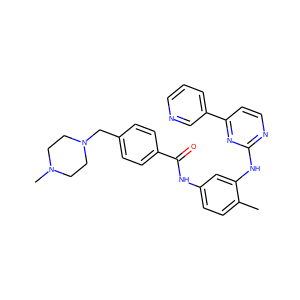

In [2]:
sti = Chem.MolFromSmiles('CN1CCN(Cc2ccc(cc2)C(=O)Nc2ccc(C)c(Nc3nccc(n3)-c3cccnc3)c2)CC1')
Draw.MolToImage(sti)

STIの３次元構造を調べるために、オープンソースツールのPyMolを使います（トークトリアルT8のイントロダクションを参照してください）。PyMolでSTIを眺める前に、３次元座標を計算する必要があります。

まず、化合物に水素原子を追加しますが、水素原子はSMILES形式でいつも明示的に記述されているとは限りません。次に、距離幾何学（ディスタンスジオメトリー法、Distance Geometry）を使って化合物の初期座標を取得し、UFF（Universal Force Field）力場を使って化合物構造の最適化を行います。

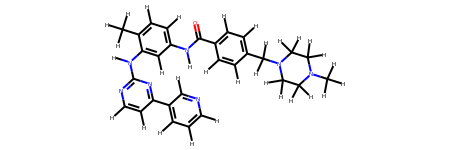

In [3]:
sti_mol = Chem.AddHs(sti)
sti_mol

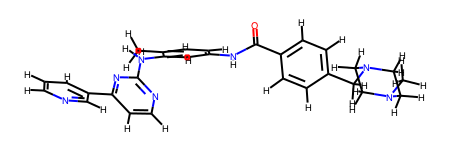

In [4]:
AllChem.EmbedMolecule(sti_mol)
AllChem.UFFOptimizeMolecule(sti_mol)
sti_mol

これで、PyMolに進む準備ができました！

ターミナルからPyMolを開きます（ここではJupyter notebookからコントロールしています）。

In [5]:
os.popen('pymol -R')

`objPMV = PyMol.MolViewer()`経由でPyMolとJupyter notebookを接続するために、PyMolが完全に立ち上がるまで待つ必要があります。

In [6]:
# エラーへの対処方法：PyMolが読み込まれるまでまつ

nrTry = 0  # 現在の試行回数
ttw = 10  # 待ち時間（秒単位）

while nrTry < ttw:  # PyMolが読み込まれオブジェクトが保存されるまで試行する
    nrTry += 1
    try:  
        objPMV = PyMol.MolViewer()  # PyMolオブジェクトの保存
        break  # PyMolが読み込まれたらループを止める        
    except ConnectionRefusedError:  # PyMolがまだ読み込まれていない場合の例外処理
        time.sleep(1)  # 待つ...
    
if nrTry == ttw:  # ttw試行の後：エラーメッセージを表示
    print("Error: PyMol did not start correctly.\n" +
          "Try again and/or check if PyMol is installed completely.")

STIをPyMolに読み込み、このJupyter notebookにPyMolフレームを表示させます。

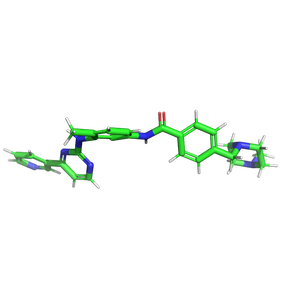

In [8]:
# PyMolを初期化（すでにPyMolにオブジェクトを読み込んでいるといけないので初期化する）
objPMV.server.do("reinitialize")

# PyMolに化合物を読み込み表示
objPMV.ShowMol(sti_mol)
# sticksで表示
objPMV.server.do('cmd.show("sticks","molecule")')
    
# PyMolの背景を白色に設定
objPMV.server.do("bg_color white")
# 現在のPyMolフレームのレイトレースイメージを作成
objPMV.server.do("ray 900, 900")

objPMV.GetPNG(h=300)

### PDBから全てのタンパク質-STI複合体を取得

PDBのような公開データベースでイマチニブ/STIを調べ、ターゲットタンパク質として報告されているタンパク質を検索することができます。PDBでは、イマチニブは通常STIとして省略されています。以下では、両方の名称を検索し結果を統合します。

#### PDBを検索

まず、対象のリガンド（STI）に結合するタンパク質をPDBから全て取得します。

In [10]:
search_dict = make_query('STI')  # PDBでリガンドSTIに結合するタンパク質を検索
found_pbd_ids = do_search(search_dict)

print(found_pbd_ids)
print("\nNumber of structures connected with STI in the PDB: " + str(len(found_pbd_ids)))

['1AVU', '1AVW', '1AVX', '1BA7', '1FPU', '1IEP', '1M52', '1OPJ', '1R8N', '1R8O', '1T45', '1T46', '1XBB', '2BEA', '2BEB', '2DRE', '2ESU', '2ET2', '2HYY', '2OIQ', '2PL0', '3EA7', '3EA8', '3FW1', '3GVU', '3HEC', '3I2A', '3I2X', '3K5V', '3M3V', '3MS9', '3MSS', '3OEZ', '3PYY', '3QQM', '3S8J', '3S8K', '4BKJ', '4CSV', '4GCN', '4GCO', '4H9W', '4HA2', '4R7I', '4TLP', '5FNW', '5FNX', '5FZU', '5FZY', '5FZZ', '5G00', '5MQT', '6HD4', '6HD6', '6I0I', '6JOL', '6KTN', '6NPE', '6NPU', '6NPV', '6OTU', '6WE5']

Number of structures connected with STI in the PDB: 62


検索対象のリガンドに使う名称（ここではイマチニブ（imatinib））によって検索結果が変わることがあることに注意してください。

In [11]:
search_dict2 = make_query('Imatinib')  # PDBでリガンド　Imatinib結合するタンパク質を検索
found_pbd_ids2 = do_search(search_dict2)

print(found_pbd_ids2)
print("\nNumber of structures connected with Imatinib in the PDB: " + str(len(found_pbd_ids2)))

['1IEP', '1M52', '1OPJ', '1T46', '1XBB', '2F4J', '2GQG', '2HYY', '2OIQ', '2PL0', '2XYN', '3EL7', '3EL8', '3FW1', '3G0E', '3G0F', '3G6G', '3G6H', '3GVU', '3HEC', '3HEG', '3K5V', '3MS9', '3MSS', '3OEZ', '3OF0', '3PYY', '3QLF', '3QLG', '4BKJ', '4CSV', '4R7I', '5MQT', '6HD4', '6HD6', '6JOL', '6KTM', '6KTN', '6NPE', '6NPU', '6NPV']

Number of structures connected with Imatinib in the PDB: 41


両方の検索結果を統合し、重複しない（ユニークな）エントリーだけを残します。

In [13]:
pdb_ids = list(set(found_pbd_ids + found_pbd_ids))
print("Number of structures connected with STI/Imatinib in the PDB: " + str(len(pdb_ids)))

Number of structures connected with STI/Imatinib in the PDB: 62


**訳注(2020/05)**  
`set()`で２つのリストの和集合をとっています（重複を削除）。set型となるため再度`list()`でリスト型にしています。  
**訳注ここまで**

#### PDBデータセットをフィルタリング

以下のクライテリアに従ってデータセットをフィルタリングするために、`pypdb`の`get_entity_info`関数を使ってPDB構造のメタ情報を取得します。

1. 実験手法でフィルタリング (`xray`)
2. 分解能でフィルタリング (3 &#8491;以下)
3. （簡単にするため）1本鎖のPDB構造のみを残す（single chain）
4. Imatinibに結合した構造のみを残す（例、Imatinibに関連づけられているが、結合はしていないPDB構造が除かれる）
5. 2019年以前に登録されたPDB IDのみを残す（トークトリアル公開時点のリソースにデータセットをあわせる）

PDBを検索する方法についての情報は**トークトリアル 8**を参照してください。

In [14]:
# PDBからメタ情報を取得
entity_info = []
for i in pdb_ids:
    entity_info.append(get_entity_info(i))
entity_info[0]

{'Method': {'@name': 'xray'},
 'Entity': {'@id': '1',
  '@type': 'protein',
  'Chain': [{'@id': 'A'}, {'@id': 'B'}]},
 'structureId': '6I0I',
 'bioAssemblies': '1',
 'release_date': 'Wed Sep 04 00:00:00 PDT 2019',
 'resolution': '1.45'}

In [15]:
# リストをデータフレームに変換
entity_info_pd = pd.DataFrame(entity_info)
a = [int(i.split(" ")[5]) for i in entity_info_pd["release_date"].tolist()]
entity_info_pd.head()

,Method,Entity,structureId,bioAssemblies,release_date,resolution
0,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': [{'@...",6I0I,1,Wed Sep 04 00:00:00 PDT 2019,1.45
1,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",5FZU,1,Wed Jul 06 00:00:00 PDT 2016,2.43
2,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",2PL0,1,Tue Oct 09 00:00:00 PDT 2007,2.80
3,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",1R8N,1,Tue May 25 00:00:00 PDT 2004,1.75
4,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': [{'@...",3M3V,1,Wed Mar 23 00:00:00 PDT 2011,2.70


In [16]:
# 1. 実験手法でフィルタリング
entity_info_pd = entity_info_pd[entity_info_pd["Method"] == {'@name': 'xray'}]

# 2. 分解能でフィルタリング
entity_info_pd = entity_info_pd[entity_info_pd["resolution"].astype(float) <= 3.0]

# 3. 1本鎖の構造のみを保持（簡単化のため）
entity_info_pd = entity_info_pd[[type(i) == dict for i in entity_info_pd["Entity"]]]

entity_info_pd = entity_info_pd[[type(i["Chain"]) == dict for i in entity_info_pd["Entity"]]]

pdb_ids = entity_info_pd["structureId"].tolist()

print("Number of structures after filtering: " + str(len(pdb_ids)))

Number of structures after filtering: 24


In [17]:
entity_info_pd.head()

,Method,Entity,structureId,bioAssemblies,release_date,resolution
1,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",5FZU,1,Wed Jul 06 00:00:00 PDT 2016,2.43
2,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",2PL0,1,Tue Oct 09 00:00:00 PDT 2007,2.80
3,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",1R8N,1,Tue May 25 00:00:00 PDT 2004,1.75
5,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",1T45,1,Tue Jun 15 00:00:00 PDT 2004,1.90
6,{'@name': 'xray'},"{'@id': '1', '@type': 'protein', 'Chain': {'@i...",1AVU,1,Wed Oct 28 00:00:00 PST 1998,2.30


**訳注**  
Chainに関する情報はカラム「Entity」の辞書型の要素のうち、「Chain」をkeyとするvalueとして格納されています。  
Chainの数に応じて、  
* Chainが1つの時 → 「'Chain': {'@id': 'A'}」  → valueのtypeはdict 
* Chainが2つの時 → 「'Chain': [{'@id': 'A'}, {'@id': 'B'}]」  → valueのtypeはlist  

のようになっており、複数のChainがある場合はvalueのtypeがlist（辞書を要素とするリスト）になります。  
従って、フィルタリング３行程目では「type(i["Chain"]) == dict」 とすることで「Chainが1つのもののみ」を残していると思われます。  
**訳注終わり**

以下では、`BioPandas`というパッケージを使用します。`BioPandas`にはpandasデータフレームに生物学的高分子（PDBからmol2ファイルまで）の分子構造を読み込むために役立つ関数があります。PDBファイルを使った作業を容易にするために`PandasPdb`オブジェクトを使います。

In [19]:
# 4. Imatinibの結合した構造だけを保持

def check_if_ligand_present(pdb_id, ligand_name):
    ppdb = PandasPdb().fetch_pdb(pdb_id)  # PDB（原子情報、座標）を取得
    return sum(ppdb.df["HETATM"]["residue_name"] == ligand_name) > 0  # エントリー　STIがあるかどうかｂ確認

entity_info_pd = entity_info_pd[[check_if_ligand_present(pdb_id, "STI") for pdb_id in pdb_ids]]  # 関数を適用

pdb_ids = entity_info_pd["structureId"].tolist()

print("Number of structures after filtering: " + str(len(pdb_ids)))

Number of structures after filtering: 9


**訳注(2020/05)**  
BioPandasのドキュメンテーションは[こちら](http://rasbt.github.io/biopandas/)です。  
`PandasPdb`オブジェクトのアトリビュート`PnadasPdb.df`DataFrameの辞書となっており、PDBファイルにpandasデータフレームのようにアクセスできます（[BioPandas Tutorial](http://rasbt.github.io/biopandas/tutorials/Working_with_PDB_Structures_in_DataFrames/))。ここではPDBファイルの**HETATM**レコードにアクセスし**残基名(residue_name)**でリガンドの名称を取得しています。

また、`check_if_ligand_present`は引数`ligand_name`が一つでもあればTrue、なければFalseを返す関数です。上記のセルではリスト内包表記で「**STI**有り無しのboolリスト」を取得し、これを使ってTrueとなる行のみをDataFrameから抽出しています。  
**訳注ここまで**

In [20]:
# 5. 2019年以前に登録されたPDB DIのみを保持

entity_info_pd = entity_info_pd[[int(i.split()[5]) < 2019 for i in entity_info_pd["release_date"].tolist()]]

pdb_ids = entity_info_pd["structureId"].tolist()

print("Number of structures after filtering: " + str(len(pdb_ids)))

Number of structures after filtering: 8


**訳注(2020/05)**  
「release date」は「例：Wed Jul 06 00:00:00 PDT 2016」という形式なので、半角スペースでsplitした6番目（インデックス5)が「年」になります。  
**訳注ここまで**

In [21]:
# 6. 手作業で目視で調べたあとで3GVUを除く（STIを２つ含む：以下の自動化ワークフローに適していない）
pdb_ids.remove("3GVU")

In [22]:
pdb_ids
# random.shuffle(pdb_ids)  # IDの順序を変えたい時に使用してください

['2PL0', '3FW1', '3HEC', '4R7I', '1XBB', '4CSV', '1T46']

#### フィルタリングしたPDB IDの保存

さらに解析を進めるため、フィルタリングしたデータセットのPDB　IDを保存します（後ほど、このファイルに従ってPDB IDを処理するPyMolのPythonスクリプトを使います）。

In [23]:
pickle.dump(pdb_ids, open("../data/T10/pdb_ids.p", "wb"))

### PDB構造の可視化

まず、タンパク質データセットの3次元構造を目視で調べるためPyMolに全構造を読み込みます。

このJupyter notebook上でのPyMolフレームの固定化したイメージ形式での可視化に加えて、PyMolアプリケーション上で直接３次元構造を眺め、インタラクティブに検証することをお勧めします。PyMolアプリケーションはこのトークトリアルと並行して立ち上り、操作されているはずです。

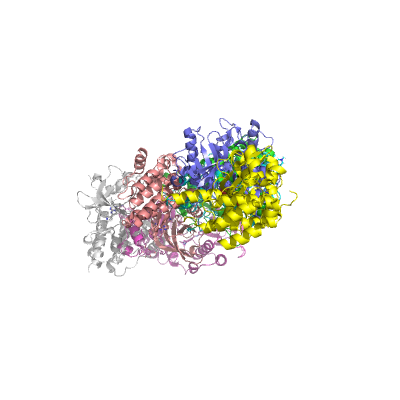

In [25]:
# PyMolの再初期化
objPMV.server.do("reinitialize")

# タンパク質ファイルの読み込み
for pdb_id in pdb_ids:
    cmd = "fetch " + pdb_id
    objPMV.server.do(cmd)

# タンパク質をcartoonとして表示（使用しているpymolのversionに応じて必要な可能性があります）
objPMV.server.do('cmd.show("cartoon","all")')

# オブジェクトを隠す
objPMV.server.do("hide polar_contacts")

# 背景を白色に設定
objPMV.server.do("bg_color white")
# 水分子とイオンを削除
objPMV.server.do("remove solvent")
# 中心に置き、ズーム
objPMV.server.do("center all")
objPMV.server.do("zoom all")
objPMV.server.do("ray 400,400")

# Jupyter noteboomにPyMolフレームを表示
objPMV.GetPNG(h=500)

このイメージは美しくカラフルでくるくると巻いていますが、まだ有益な情報を与えてくれません。次のステップではこの構造を互いに重ね合わせます（アラインメント）。

### PDBの構造をアラインメント（タンパク質全体）

PyMolはさまざまなレベルの配列類似性と構造類似性に適した、異なるアラインメント手法を提供しています：

* [`super`](https://pymolwiki.org/index.php/Super)コマンドは*かなりの構造類似性（decent structural similarity）*のあるタンパク質に適しています（配列には依存しない）。
* [`align`](https://pymolwiki.org/index.php/Align)コマンドは*かなりの配列類似性（decent sequence similarity）*のあるタンパク質に適しています（配列に依存）。
* [`cealign`](https://pymolwiki.org/index.php/Cealign) コマンドは*ほとんどあるいは全く配列類似性がない（little to no sequence similarity）*タンパク質に対して頑健な手法です（配列依存性は中間）

このトークトリアルでは`align`コマンドを選択し、（配列に基づいて）RMSDを最小化することで構造を重ね合わせます。

注：このアプローチは類似の配列を持つ構造に有利なように解析されます（`align`コマンドはかなりの配列類似性をもつタンパク質のペアでパフォーマンスがより良くなります）。配列類似性が低いタンパク質の比較には`super`あるいは`cealign`コマンドの方が選択肢として良いかもしれません。（タンパク質ペアの配列や構造類似性がわからない）自動化されたワークフローにの場合、３つの全ての手法に基づいてRMSDを計算し、最も結果の良いものをさらなる解析のために残すことが解決策となるかもしれません。

まず、`pdb_ids`リストの全ての構造を一番最初の構造に対してアラインメントをとります。

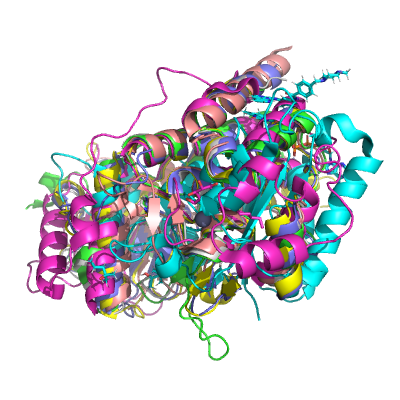

In [26]:
immobile_pdb_id = pdb_ids[0]
for mobile_pdb_id in pdb_ids[1:]:
    objPMV.server.do("align " + mobile_pdb_id + ", " + immobile_pdb_id)

objPMV.server.do("center all")
objPMV.server.do("zoom all")
objPMV.server.do("ray 400,400")

objPMV.GetPNG(h=500)

タンパク質のうちの一つ、3FW1は他のタンパク質と比較して重なりが悪くなっています。重なりの良いタンパク質を表示させるために、このタンパク質を隠します。

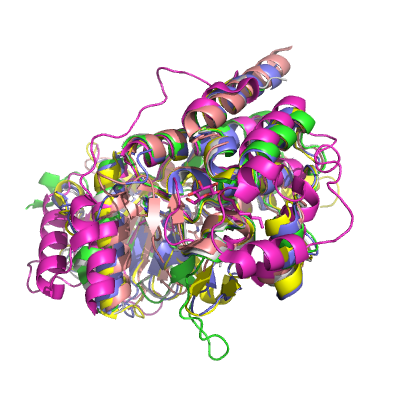

In [27]:
objPMV.HideObject("3FW1")

objPMV.server.do("center all")
objPMV.server.do("zoom all")
objPMV.server.do("ray 400,400")

objPMV.GetPNG(h=500)

多くの部分（例、ヘリックス）では構造の重なりの程度は高いですが、他の部分では重なりは低いか悪くなっています。

### ペアワイズRMSDの取得（タンパク質全体）

（PyMolとPyMol Pythonスクリプトでは*可能*ですが）このJupyter notebook上ではPyMolからRMSD値を取得する関数を見つけられなかったので、PyMolのPythonスクリプトを呼びます。PyMol Pythonスクリプトでは全てのタンパク質のペアについて重ね合わせと最終的なRMSDのリファインを行います。結果としてえらえれるRMSD値をさらなる解析のために保存しておきます。

まず、このタスクのために使う、PyMolのPythonスクリプトを見ます。

In [29]:
f = open("./pymol_scripts/pymol_align_proteins.py")
file_content = f.readlines()
for i in file_content:
    print(i, end="")

'''
This script aligns all pairs of input proteins.
'''
# 訳者実行環境の都合上pymolのpathを追加するために以下2行追記
import sys
sys.path.append('/usr/local/Cellar/pymol/2.3.0/libexec/lib/python3.7/site-packages')
# 追記終わり。以降オリジナルスクリプト

import pymol
import pickle
import pandas as pd
import sys
import numpy as np

# Launch PyMol
pymol.finish_launching()

# Load PDB IDs
pdb_ids = pickle.load(open("../data/T10/pdb_ids.p", "rb"))

# Create DataFrame to store align results
align_df = pd.DataFrame(index=pdb_ids, columns=pdb_ids)

def align_structures(m1, m2, align_df):
	# Fetch PDB structures
	pymol.cmd.fetch(m1, "i")
	pymol.cmd.fetch(m2, "m")

	# Align proteins
	aln = pymol.cmd.align(mobile="m", target="i", quiet=1, object="{}_{}".format(m1, m2))

	# Save align results to DataFrame
	align_df.loc[m1, m2] = aln

	# Save sequence alignment to file
	pymol.cmd.save(filename="../data/T10/alignment/alignment_proteins_" + "{}_{}".format(m1, m2) + ".aln", selection="{}_{}".format(m1, m2))

	# Reinitialize PyMol for next stru

In [30]:
os.popen("python ./pymol_scripts/pymol_align_proteins.py")

**訳注**  
アラインメント結果が保存されていない場合、Pythonスクリプトのエラーの可能性があります。  
私の実行環境ではターミナル上で*ModuleNotFoundError: No module named 'pymol'* が確認できたため、PyMolのPathを追加したところ実行することができました。  
**訳注終わり**

このPyMol Pythonスクリプトは全てのペアワイズRMSDの結果をファイルに保存します。それでは結果をJupyter notebookに読み込みます。

In [31]:
align_df_proteins = pickle.load(open("../data/T10/align_df_proteins.p", "rb"))

`align_df_proteins`は各ペアワイズの比較についてPyMolの`align`コマンドの戻り値、つまり7項目のタプル、を含むデータフレームです：

1. リファイン後のRMSD
2. リファイン後の重ね合わされた原子の数
3. リファインメントサイクルの試行数
4. リファイン前のRMSD
5. リファイン前の重ね合わされた原子の数
6. アラインメントスコアの生の値
7. 重ね合わされた残基の数

１つのタンパク質ペアを例に、このデータ構造に慣れ親しんでみます。

In [32]:
print("Structures in the data set:")
cols = align_df_proteins.columns
rows = align_df_proteins.index
print(cols)
print(rows)

example_col = cols[0]
example_row = rows[2]
print("\nExample align return values for the {}-{} pair: ".format(example_col, example_row))
print(align_df_proteins.loc[example_col, example_row])

print("\nRMSD value (in Angström) after refinement for the {}-{} pair: ".format(example_col, example_row))
print(align_df_proteins.loc[example_col, example_row][0])

Structures in the data set:
Index(['1XBB', '2PL0', '4R7I', '3HEC', '4CSV', '1T46', '3FW1'], dtype='object')
Index(['1XBB', '2PL0', '4R7I', '3HEC', '4CSV', '1T46', '3FW1'], dtype='object')

Example align return values for the 1XBB-4R7I pair: 
(1.0288203954696655, 1167, 5, 6.308946132659912, 1539, 404.5, 245)

RMSD value (in Angström) after refinement for the 1XBB-4R7I pair: 
1.0288203954696655


さて、全てのペアについてリファイン後のRMSD（あるいはその他の`align`の戻り値のどれでも）を取り出し、さらなる解析のためPandsデータフレームとします。

従って、`pymol_align_results`の全てのペアに関する`align`関数の戻り値、および、知りたい`position`の戻り値の位置を入力とする関数を定義します。

In [33]:
def extract_align_info(align_df, position):
    if position in [0, 3, 5]:
        return align_df.applymap(lambda x: np.float(x[position]))
    if position in [1, 2, 4, 6]:
        return align_df.applymap(lambda x: np.int(x[position]))
    else:
        print("Position not available.")

例えば、タンパク質の各ペアについて、重ね合わされた残基の数をチェックすることができます（`align`の戻り値の最後の位置）。

In [34]:
extract_align_info(align_df_proteins, 6)

,1XBB,2PL0,4R7I,3HEC,4CSV,1T46,3FW1
1XBB,292,272,245,159,249,258,81
2PL0,272,290,267,207,269,261,146
4R7I,245,267,344,186,263,308,26
3HEC,159,207,186,350,243,196,90
4CSV,249,269,263,243,276,269,47
1T46,258,261,308,196,269,316,101
3FW1,81,146,26,90,47,101,238


ここでは、ほとんどのタンパク質のペアについて、残基の大部分が重ね合わせできていることがわかります（ここではEGFR配列の長さは270から350の範囲をとっています）。しかしながら、3FW1の配列のアラインメントは低くなっています。

参考までに：全てのペアの配列アラインメントは`../data/T10/alignment/`でチェックできます。例を下に示します。

In [35]:
example_alignment_path = glob.glob("../data/T10/alignment/*")[3]
f = open(example_alignment_path)
file_content = f.readlines()
for i in file_content:
    print(i, end="")

CLUSTAL

i            MALEEIRPKEVYLDRKLLTLED---------------------------------KELGSGNF
m            MKKGHHHHHHGQKPKYQVRWKIIESYEGNSYTFIDPTQLPYNEKWEFPRNNLQFGKTLGAGAF
                                                                    *.**.*.*

i            GTVKKGYYQM----KKVVKTVAVKILKNEANDPALKDELLAEANVMQQL-DNPYIVRMIGICE
m            GKVVEATAFGLGKEDAVLK-VAVKMLKSTAHADE-KEALMSELKIMSHLGQHENIVNLLGACT
             *.*..         .     ****.**        *..*..*...*..* ....**...*.* 

i            AESWMLVM-EMAELGPLNKYLQQNR-----------------------HVKDKNIIELVHQVS
m            HGGPVLVITEYCTYGDLLNFLRRKAEAMLGPSLSPGQDPEGLDKEDGRPLELRDLLHFSSQVA
                      *....*.*...*...                        ............**.

i            MGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPE
m            QGMAFLASKNCIHRDVAARNVLLTNGHVAKIGDFGLARDIMNDSNYIVKGNA-RLPVKWMAPE
             .**..*...*..***.*******.   .***.*                    ..****.***

i            CINYYKFSSKSDVWSFGVLMWEAFSYGQKPYRGM-KGSEVTAMLEKGERM

次のステップでは、リファイン後のRMSD値のデータフレームを作成します（`align`の戻り値の最初の位置）。

In [36]:
rmsd = extract_align_info(align_df_proteins, 0)
rmsd

,1XBB,2PL0,4R7I,3HEC,4CSV,1T46,3FW1
1XBB,0.000000,1.549436,1.028820,2.560788,0.897684,1.132188,15.648476
2PL0,1.549436,0.000000,1.161164,1.894447,0.871177,1.021322,19.819407
4R7I,1.028820,1.161164,0.000000,2.022787,0.736076,0.687878,7.503986
3HEC,2.560788,1.894447,2.022787,0.000000,1.683216,1.912085,14.695195
4CSV,0.897684,0.871177,0.736076,1.683216,0.000000,0.671700,16.296894
1T46,1.132188,1.021322,0.687878,1.912085,0.671700,0.000000,15.937148
3FW1,15.648476,19.819407,7.503986,14.695195,16.296894,15.937148,0.000000


この改善されたRMSDの結果をヒートマップとして可視化します。

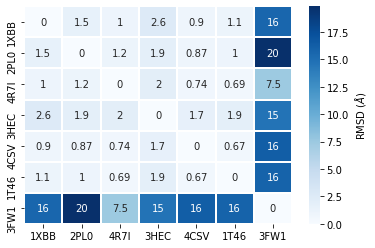

In [37]:
sns.heatmap(rmsd, linewidths=1, annot=True, cbar_kws={"label": "RMSD ($\AA$)"}, cmap="Blues")
plt.show()

リファイン後のRMSDに基づいてタンパク質の類似性を見るためにヒートマップをクラスタリングします。

In [38]:
def plot_clustermap(rmsd, title):
    g = sns.clustermap(rmsd, linewidths=1, annot=True, cbar_kws={"label": "RMSD ($\AA$)"}, cmap="Blues")
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    sns.set(font_scale=1.5)
    
    # プロットの保存ーテキストボックスを含めるためにbbox_inchesを使います：
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig("../data/T10/bsc_{}.png".format(title), dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

/Users/macnakamura/.pyenv/versions/anaconda3-5.3.1/envs/teachopencadd/lib/python3.6/site-packages/seaborn/matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


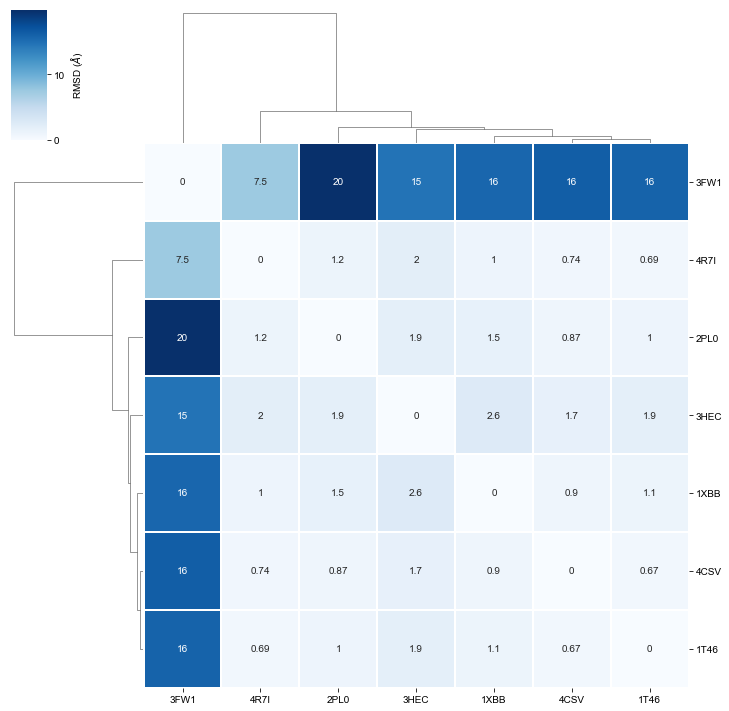

In [39]:
plot_clustermap(rmsd, "protein")

RMSDの比較により、一つのタンパク質、つまり3FW1が他の全てのタンパク質とは異なっていることが示されました（既にアラインメントを３次元で目視で検証した結果と、重ね合わされた残基の数に基づいておこなった議論のとおりです）。

タンパク質は触媒する化学反応によって、いわゆるEC（Enzyme Commission）番号で分類されます。ここでは、このEC番号をタンパク質が属する酵素グループを確認するために使います。

In [40]:
# PDBからPDB IDのEC番号を取得
pdb_all_info = [get_all_info(pdb_id) for pdb_id in pdb_ids]
ec_numbers = [i["polymer"]["enzClass"]["@ec"] for i in pdb_all_info]
target_set = {"pdb_id": pdb_ids,
              "ec_number": ec_numbers}
target_set = pd.DataFrame(target_set)
target_set

,pdb_id,ec_number
0,2PL0,2.7.10.2
1,3FW1,1.10.5.1
2,3HEC,2.7.11.24
3,4R7I,2.7.10.1
4,1XBB,2.7.10.2
5,4CSV,2.7.10.2
6,1T46,2.7.10.1


3FW1、つまりヒトキノン還元酵素２（human quinone reductase 2、NQO2）はEC class 1、つまり酸化還元酵素（oxidoreductases）に属している一方で、他のタンパク質は全てEC class 2.7、つまりリン酸転移酵素（phosphorus transferases）に属しています。EC class 2.7はチロシンキナーゼ（EC 2.7.10.2）を含んでおり、これはイマチニブの目標とするターゲットです。3FW1は「医薬品デザインと慢性骨髄性白血病（chronic myelogenous leukemia）患者の治療に潜在的に関与しうる」オフターゲットとして報告がなされています([<i>BMC Struct. Biol.</i> (2009), <b>9</b>, 10.1186/1472-6807-9-7](https://bmcstructbiol.biomedcentral.com/articles/10.1186/1472-6807-9-7))。

### PDBの構造をアラインメント（結合サイト）

ここまでアラインメントとRMSDのリファインメントにタンパク質全体の構造を使ってきました。ですが、リガンドはタンパク質の結合サイトだけに結合し、従ってタンパク質全体よりもむしろ結合サイトの類似性がオフターゲットを予測するうえでより確からしい基準とされています。

リガンド原子のいずれかの10 &#8491; 以内となる残基全てを選択することで、タンパク質の結合サイトを定義します。これらの結合サイトの残基をアラインメントに用い、 C&#593; 原子（タンパク質主鎖）だけをRMSDのリファインメントに用います。ここでは、`pdb_ids`リストの全ての構造を一番最初の構造に対してアラインメントをとります。

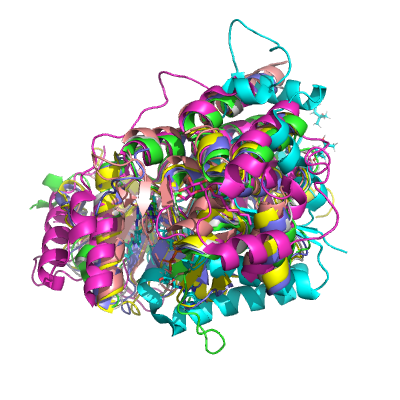

In [42]:
# PyMolの再初期化
objPMV.server.do("reinitialize")

# タンパク質ファイルの読み込み
for pdb_id in pdb_ids:
    cmd = "fetch " + pdb_id
    objPMV.server.do(cmd)

# cartoonとしてタンパク質を表示（使用しているpymolのversionに応じて必要な可能性があります）
#objPMV.server.do('cmd.show("cartoon","all")')

# オブジェクトを隠す
objPMV.server.do("hide polar_contacts")

# 背景を白色に設定
objPMV.server.do("bg_color white")
# 水分子とイオンを除去
objPMV.server.do("remove solvent")

# 結合サイトのアラインメント
immobile_pdb_id = pdb_ids[0]
for mobile_pdb_id in pdb_ids[1:]:
    # STIのいずれかの原子と一定の半径以内にある原子を選択し、選択を残基全体に拡張
    objPMV.server.do("select mobile_bs, byres " + mobile_pdb_id + " within 10 of (" + mobile_pdb_id + " and resn STI)")
    objPMV.server.do("select immobile_bs, byres " + immobile_pdb_id + " within 10 of (" + immobile_pdb_id + " and resn STI)")
    # アラインメントを実行
    objPMV.server.do("align mobile_bs, immobile_bs")

# 中心に置き、ズーム
objPMV.server.do("center all")
objPMV.server.do("zoom all")
objPMV.server.do("ray 400,400")

# Jupyter notebookにPyMolフレームを表示
objPMV.GetPNG(h=500)

### ペアワイズRMSDの取得（結合サイト）

タンパク質構造全体のアラインメントとRMSDのリファインメントで先に示したのと同様に、ここでは全てのタンパク質の結合サイトのペアについてアラインメントとRMSDを計算するPyMol Pythonスクリプトを実行します。

使用するPyMolコマンドはPyMol Pythonスクリプトの中で説明されています。

In [43]:
f = open("./pymol_scripts/pymol_align_bindingsites.py")
file_content = f.readlines()
for i in file_content:
    print(i, end="")

'''
This script aligns all pairs of input proteins (binding sites).
'''
# pymolのpathを追加するために以下2行追記
import sys
sys.path.append('/usr/local/Cellar/pymol/2.3.0/libexec/lib/python3.7/site-packages')
# 追記終わり
import pymol
import pickle
import pandas as pd
import sys
import numpy as np

# Launch PyMol
pymol.finish_launching()

# Get the parameter (radius from ligand)
radius = sys.argv[1]

# Load PDB IDs
pdb_ids = pickle.load(open("../data/T10/pdb_ids.p", "rb"))

# Create DataFrame to store align results
align_df = pd.DataFrame(index=pdb_ids, columns=pdb_ids)

def align_structures(m1, m2, align_df):
	# Fetch PDB structures
	pymol.cmd.fetch(m1, "i")
	pymol.cmd.fetch(m2, "m")

	# Select binding site
	pymol.cmd.select("i_bs", "byres i within " + radius + " of (i and resn STI)")
	pymol.cmd.select("m_bs", "byres m within " + radius + " of (m and resn STI)")

	# Align binding sites
	aln = pymol.cmd.align(mobile="m_bs", target="i_bs", quiet=1)

	# Save align results to DataFrame
	align_df.loc[m1, m2]

PyMol Pythonスクリプトをターミナル経由で実行します（結合サイトの原子を定義するためリガンドータンパク質半径を入力とます）。

In [44]:
# PyMolのalign関数を追加って結合サイトの比較を実施
os.popen("python ./pymol_scripts/pymol_align_bindingsites.py 10")

結合サイト比較のために`align`データフレームを読み込みます。

In [45]:
align_df_bindingsites = pickle.load(open("../data/T10/align_df_bindingsites.p", "rb"))

データフレームからRMSD値を抜き出します。

In [46]:
rmsd_bs = extract_align_info(align_df_bindingsites, 0)

In [47]:
extract_align_info(align_df_bindingsites, 6)

,2PL0,3FW1,3HEC,4R7I,1XBB,4CSV,1T46
2PL0,87,6,67,81,51,79,85
3FW1,6,38,4,6,7,8,6
3HEC,67,4,83,68,48,67,69
4R7I,81,6,68,90,59,83,86
1XBB,51,7,48,59,65,57,55
4CSV,79,8,67,83,57,83,79
1T46,85,6,69,86,55,79,98


RMSDの結果のクラスタリングしたヒートマップを表示します。

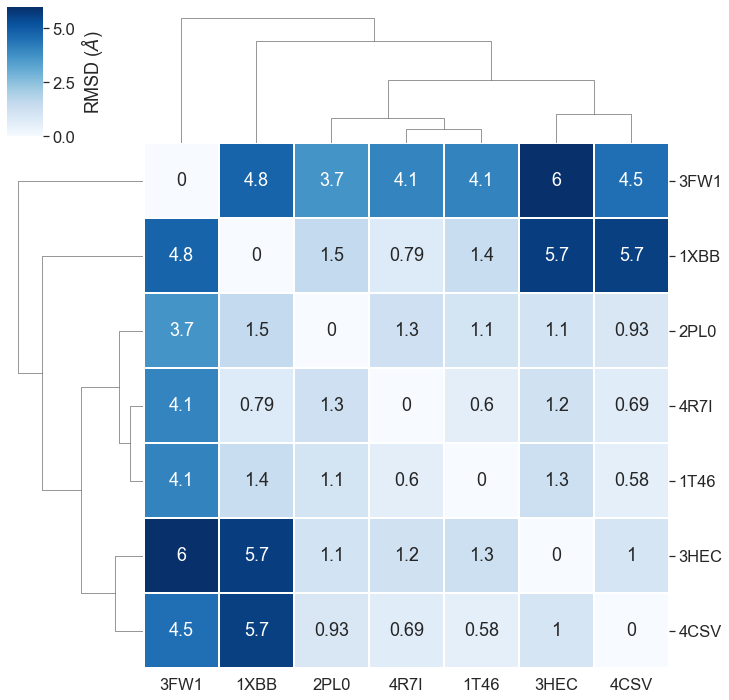

In [48]:
# ペアワイズRMSD値をクラスタリングしたヒートマップとして表示
plot_clustermap(rmsd_bs, "bs")

アラインメントをとった結合サイトのRMSD値はデータセット（EC number 2.7）における3FW1（EC number 1.10.5.1）の非類似性を示していて、PyMol上の目視による検証でもSTIがタンパク質表面上に結合していることがわかります。1XBB-4CSVと1XBB-3HECのペアも類似性が低いことを示している一方で、データセットの残りはRMSD値が低くなっています。

ここで計算したRMSD値は残基の選択（結合サイトの定義）と、あらかじめ与えられた配列のアラインメントの質に依存します。

In [49]:
# ディレクトリを綺麗にする（ダウンロードしたPDBとPyMolアラインメントファイルを除去）
os.popen("rm ./*.cif")
os.popen("rm ../data/T10/alignment/*.aln")

## ディスカッション

このトークトリアルでは、イマチニブに結合するタンパク質のセットにおける類似性と非類似性を評価するために、タンパク質全体と結合サイトについて、配列のアラインメントとそれに続くRMSDのリファインメントを行いました。しかしながら、イマチニブのオフターゲットの予測のためには、解かれた構造の巨大なデータベース（PDB）と、イマチニブの目的のターゲット（チロシンキナーゼ）の結合サイトとを比較する必要があります。この場合、類似性の低い配列の比較もおこなうことになるので、より洗練された検索を可能とするために、配列に依存しないアラインメントアルゴリズムを使う手法や、結合サイトの物理化学的特性を含む手法といった、より洗練された手法が求められます。

## クイズ

1. 医薬品のオンターゲット（on-target）とオフターゲット（off-target）という用語を説明してください。
2. なぜ結合サイト類似性が、クエリタンパク質のオフターゲットを見つけるのに使えるか説明してください？
3. オフターゲットを予測する上で(i)タンパク質全体と(ii)タンパク質結合サイトのRMSD値がどう役にたつか議論してください。
4. 結合サイトの情報にについて代わりとなるアプローチについて考えてください（結合サイトの比較のためにどうやって結合サイトをエンコードするか？）。